Yue write this code at 2023/08/02.

The aim is to test the cogging force impact on our compliance control. I just write a simple compliance control code to make the motor behave like a torsional spring (just control the torque to be $K*\Delta\theta$)

The result shows that the cogging force will make our compliance control have a low error on the position estimation (not always on the balance point computed by the equilibruim equation)

In [6]:
import odrive
from odrive.enums import *
import time
import math
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from IPython.display import clear_output
import numpy as np
import serial
import pickle


def check(my_drive):
    if my_drive.axis1.error == 0:
        print('Everything is fine')
    else:
        print('Error!')


def lowpass_filter(data,cutoff,fs,order):
    b,a=butter(order,2*cutoff/fs,btype='low',analog=False)
    y=filtfilt(b,a,data)
    return y 

In [7]:
# Find a connected ODrive (this will block until you connect one)
print("finding an odrive...")
my_drive = odrive.find_any()
print("Found! and the bus voltage is " + str(my_drive.vbus_voltage) + "V")
print(my_drive.axis1.motor.current_control.i_gain)
my_drive.axis1.motor.current_control.i_gain = 4
print(my_drive.axis1.motor.current_control.i_gain)

# calibration and enter closed control mode
# print("starting calibration...")
# my_drive.axis1.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
# while my_drive.axis1.current_state != AXIS_STATE_IDLE:
#     time.sleep(0.1)
# check(my_drive)
# my_drive.axis1.motor.config.pre_calibrated = True
# my_drive.axis1.encoder.config.pre_calibrated =True
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.controller.input_torque = 0
check(my_drive)
print('*'*50)


finding an odrive...
Found! and the bus voltage is 22.456274032592773V
82.6633529663086
4.0
Everything is fine
**************************************************


In [8]:
print(my_drive.axis1.motor.config.torque_constant)
my_drive.axis1.motor.config.torque_constant=3.9
print(my_drive.axis1.motor.config.torque_constant)

1.0
3.9000000953674316


In [10]:
my_drive.axis1.controller.config.control_mode = 3
print(my_drive.axis1.controller.config.pos_gain)
my_drive.axis1.controller.config.pos_gain=50
print(my_drive.axis1.controller.config.pos_gain)
my_drive.axis1.controller.input_pos=154/360
check(my_drive)

20.0
50.0
Everything is fine


In [16]:
t0=time.monotonic()
delta=time.monotonic()-t0

my_drive.axis1.controller.config.control_mode = 1

desired_pos=150
STIFFNESS=3 #unit:N*mm/degree


all_time=[]
all_pos=[]
all_cur=[]
all_input=[]

input_tor=0
sample_num=0

while delta<30:
    delta=time.monotonic()-t0
    now_position=my_drive.axis1.encoder.pos_circular*360 #unit:degree
    
    #controller
    pos_error=desired_pos-now_position
    input_tor=STIFFNESS*pos_error
    if input_tor>0:
        input_tor=min(input_tor,80)
    else:
        input_tor=max(input_tor,-80)
    my_drive.axis1.controller.input_torque=input_tor

    #record data
    all_time.append(delta)
    all_pos.append(now_position)
    all_input.append(input_tor)



    sample_num+=1
    if sample_num%10==0:
        clear_output()
        print('STIFFNESS:{:.2f} \nDESIRED_POSITION:{:.2f} \nPOSITION: {:.2f} \nINPUT: {:.2f}'.format(STIFFNESS,desired_pos,now_position,input_tor))
        check(my_drive)


my_drive.axis1.controller.input_torque=0
test_data=[all_time,all_pos,all_input]
filepath='./test/impedance_control_at_{}degree_with_k={}.pkl'.format(desired_pos,STIFFNESS)
pickle.dump(test_data,open(filepath,'wb'))

STIFFNESS:3.00 
DESIRED_POSITION:150.00 
POSITION: 157.55 
INPUT: -22.64
Everything is fine


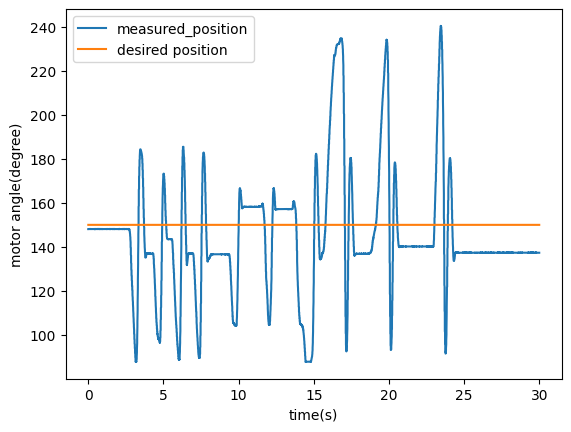

In [14]:
plt.plot(all_time,all_pos,label='measured_position')
desire=[desired_pos]*len(all_time)
plt.plot(all_time,desire,label='desired position')
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('motor angle(degree)')
# plt.plot(all_time,all_input)
# plt.ylim(108,112)
# plt.xlim(2.5,7.5)
plt.show()